In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username= "root",
                             password = "Shreya@444",
                             database = "ecommerce")
                    
cur = db.cursor()



# list all unique cities where customers are located

In [ ]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

# Count the number of orders placed in 2017

In [ ]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

data[0][0]

"total orders placed in 2017 are", data[0][0]

# Find the total sales per category

In [ ]:
query = """ select upper (products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id 
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Category" , "Sales"])
df

# Calculate the percentage of orders that were paid in installments

In [ ]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

data

 # Count the number of customers from each state

In [ ]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns= ["state" , "customer_count"])
df = df.sort_values(by = "customer_count", ascending =False)

plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("ylabel")
plt.title("Count of customers by states")
plt.show()

# Calculate the number of orders per month in 2018

In [ ]:
query = """ select monthname(order_purchase_timestamp)months , count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February" , "March" , "April" , "May" , "June" , "July" , "August" , "September" , "October"]

ax = sns.barplot(x = df["months"], y = df["order_count"] , data = df , order = o )
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city

In [ ]:
query = """ with count_per_order as
(select orders.order_id , orders.customer_id , count(order_items.order_id) as oc 
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city , round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data ,columns = ["customer city" , "average products/order"])
df.head(10 )



# Calculate the percentage of total revenue contributed by each product category

In [ ]:

query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales_percentage desc 
"""

cur.execute(query)


df = pd.DataFrame(data, columns = ["Category" , "Percentage Distribution"])
df.head(5)

#  Identify the correlation between product price and the number of times a product has been purchased

In [47]:
cur = db.cursor()
query = """
select products.product_category,
       count(order_items.product_id) as order_count,
       round(avg(order_items.price), 2) as avg_price
from products
join order_items
    on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count", "avg_price"])
df

arr1 = df["order_count"]
arr2 = df["avg_price"]

a = np.corrcoef([arr1,arr2])
print ("the correlation between price and number of times a product has been purchased is" , a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157556


# Calculate the total revenue generated by each seller, and rank them by revenue

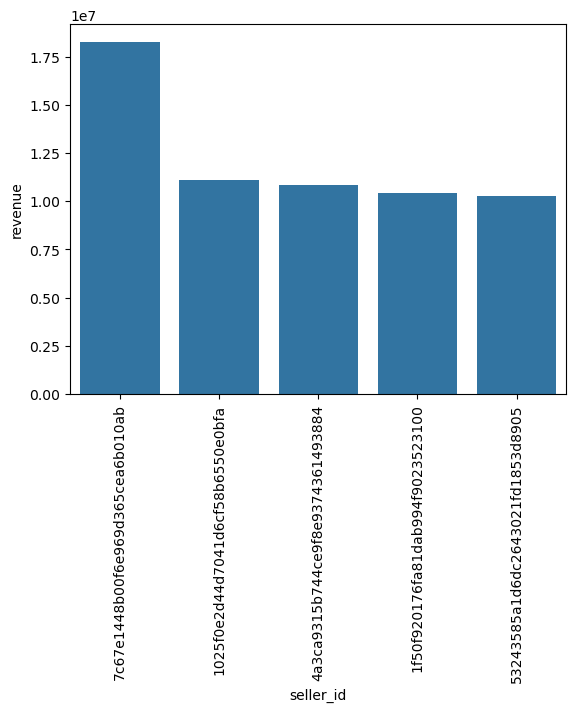

In [51]:
query = """select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a""" 

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["seller_id" , "revenue" , "rank"])
df = df.head()
sns.barplot( x = "seller_id" , y = "revenue" , data = df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [55]:
query = """select customer_id , order_purchase_timestamp , payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
3739891,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739892,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739893,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739894,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [61]:
query = """
SELECT 
    years,
    months,
    payment,
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        MONTH(orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
) AS a
ORDER BY years, months;
"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,9080.64,9.080640e+03
1,2016,10,2127257.28,2.136338e+06
2,2016,12,706.32,2.137044e+06
3,2017,1,4985569.44,7.122614e+06
4,2017,2,10508688.34,1.763130e+07
5,2017,3,16195089.58,3.382639e+07
6,2017,4,15040369.06,4.886676e+07
7,2017,5,21345077.52,7.021184e+07
8,2017,6,18405949.69,8.861779e+07
9,2017,7,21325785.10,1.099436e+08


# Calculate the year-over-year growth rate of total sales

In [64]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment, 1) over(order by years))/
lag(payment, 1)over(order by years)) *100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["years" , "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [66]:
query ="""WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders 
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT  
        a.customer_id,
        COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders
        ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 
    100 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id) AS repeat_rate
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('0.0000'),)]

# Identify the top 3 customers who spent the most money in each year

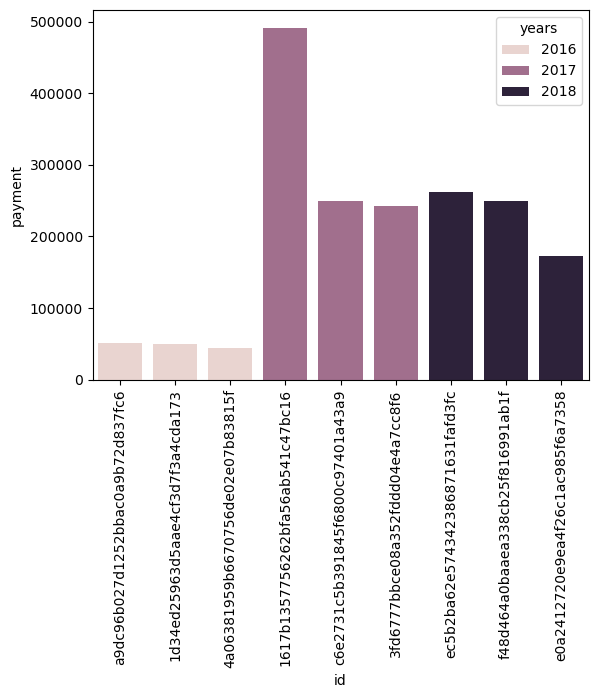

In [69]:
query = """select years ,customer_id , payment , d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["years" , "id", "payment" , "rank"])
sns.barplot(x = "id" , y = "payment" , data = df ,hue = "years")
plt.xticks(rotation=90)
plt.show()